Importing the Packages:

In [1]:
#import libraries
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm
import glob

#pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, Subset

#intern library that is used to pull 3D brain volume form BossDB
import segmentation_models_pytorch as smp      #SMP library: https://github.com/qubvel/segmentation_models.pytorch; For models and for calculation of metrics
import lib.medzoo as medzoo

from scripts.loading_model import load_model
from scripts.load_pretrained_weights import load_weights

The `BossDBDataset` class is used to download the required slices of brain imaging data from `BossDB`. Let's import it from the cloned MTNeuro package:

In [2]:
#BossDB dataset loader
from kasthuri.bossdbdataset import BossDBDataset       

## Loading the appropriate Configuration File and Selecting Model Type

**task config**: Settings corresponding to the task, like the x, y and z region of the slices. 

**network config**: Settings corresponding to the model and the training, like model layer sizes, training batch size, etc. 

In [3]:
#load the task config for specified setting that 
#(specifies the x,y ranges to pick from the data for forming the slices)

root = "../kasthuri/"

with open(os.path.join(root, f"taskconfig/synapse_task.json")) as file:
    task_config = json.load(file)

In [4]:
# Choose a model type by uncommenting the desired model line and commenting out the others.

model_type = "unet"          # Default model type is set to "unet"
# model_type = "depth"       # Uncomment this line to choose the "depth" model
# model_type = "residual"    # Uncomment this line to choose the "residual" model
# model_type = "attention"   # Uncomment this line to choose the "attention" model


task = "synapse"

dimensions = 2 # mode

In [5]:
# Load the appropriate network configurations JSON files

# dictionary, list, set of models 
if model_type == "unet":
    with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D.json")) as file:
        network_config = json.load(file)
else:
    with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D_{model_type}.json")) as file:
        network_config = json.load(file)

## Loading the Model and the corresponding pre-trained weights

Importing the custom `load_model()` method from `loading_model.py` for loading the specified model:

#### Loading the Model

Specify the device onto which you want load the model and utilize `load_model()` method.

**Syntax**: `model_object = load_model(<network configuration file for the model>, <device onto which to load the model>)`

In [6]:
# Specify device
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

model_object = load_model(network_config, device)

loading UNet model


## Loading the pre-trained weights to the model

If you need to download model weights, uncomment out the command below and run. (Make sure you have AWS CLI installed)

In [ ]:
# !aws s3 cp --recursive --no-sign-request s3://bossdb-datalake/public/kasthuri-challenge-pretrained-weights/ ./pretrained_model_weights/

The custom `load_weights()` method loads the downloaded pretrained weights into the specified `model_object`

**Syntax**: `model_object = load_weights(<model type>, <task>, <the object of the actual model>)`

In [7]:
model_object = load_weights(network_config["model_type"], task, model_object)

Successfully loaded pre-trained weights into the unet Model


## Preparing the DataLoader using BossDBDataset

**BossDBDataset**: Helper class that utilizes the `intern` library to download 3D brain volume from BossDB and convert it into a suitable PyTorch dataloader of image slices.

Note: The `ToTensor` transform needs to be applied in order to enable the conversion from numpy to PyTorch tensor.

In [8]:
##Set-up the test dataloader
test_data = BossDBDataset(task_config, None, 'test')

test_dataloader = DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

/Users/latchtd1/Documents/kasthuri_challenge/.venv/lib/python3.11/site-packages/intern/convenience/array.py:922: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn(


Unique values in mask_array before conversion: [  0 409 418 427 452 453 511 525]
Unique values in mask_array after conversion: [0 1]


## Model Prediction

#### Prediction Function


In [9]:
#function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)  # to torch, send to device
        with torch.no_grad():
            out = model(x)  # send through model/network

        out_argmax = torch.argmax(out, dim=1)  # perform softmax on outputs
        return out_argmax

#### Prediction Loop


/Users/latchtd1/Documents/kasthuri_challenge/kasthuri/bossdbdataset.py:240: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  image = torch.FloatTensor(image_array) / 255.


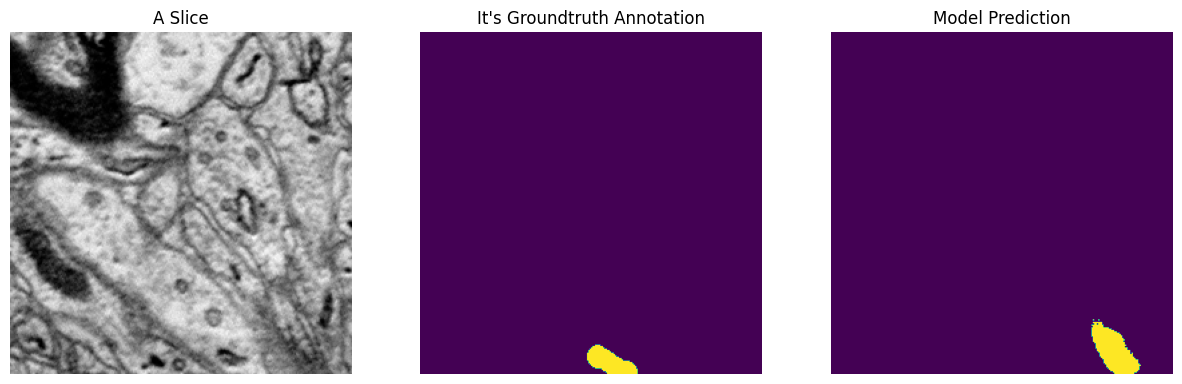

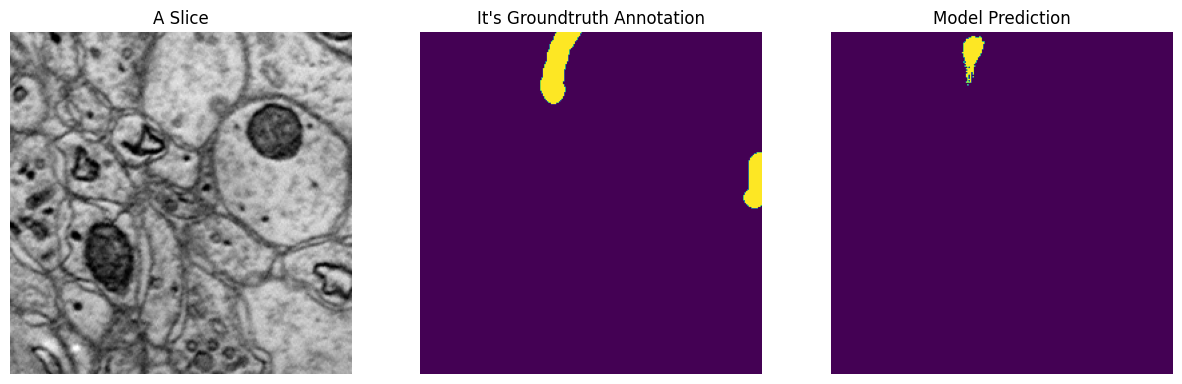

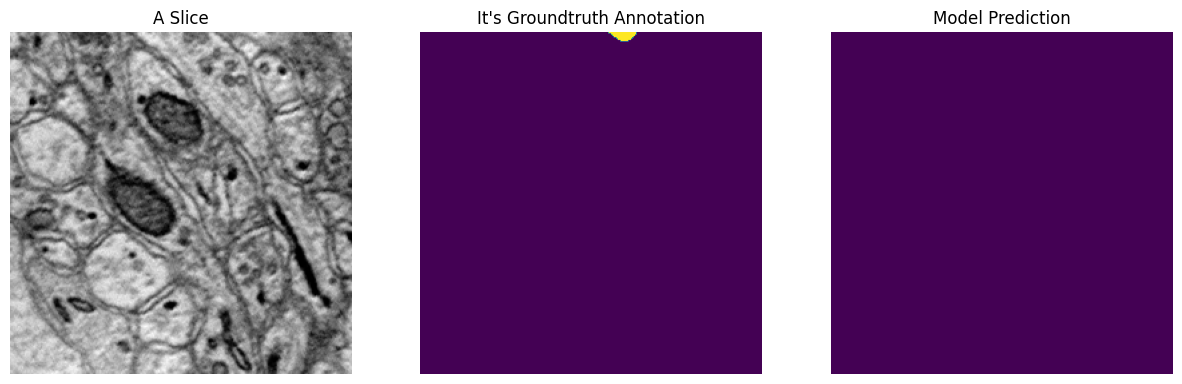

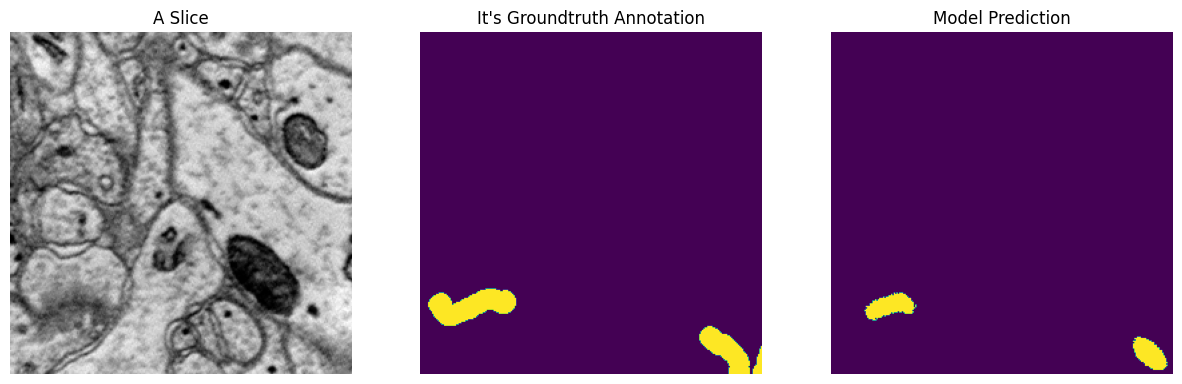

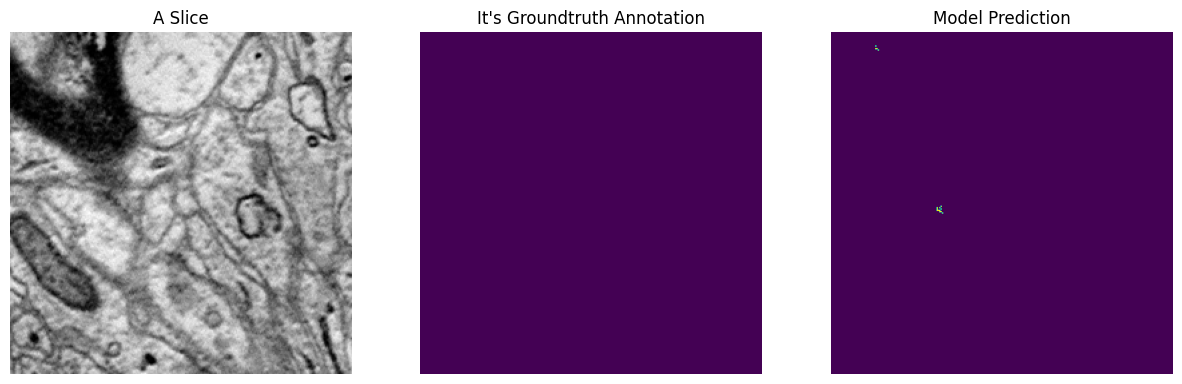

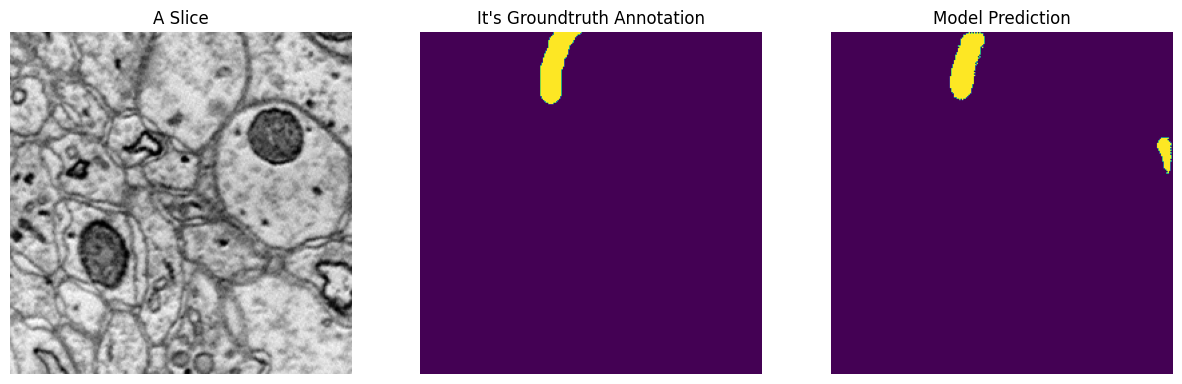

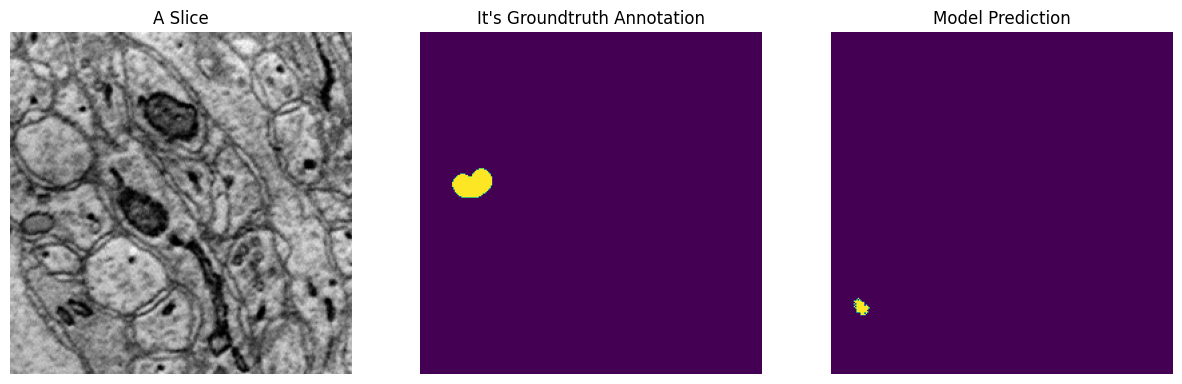

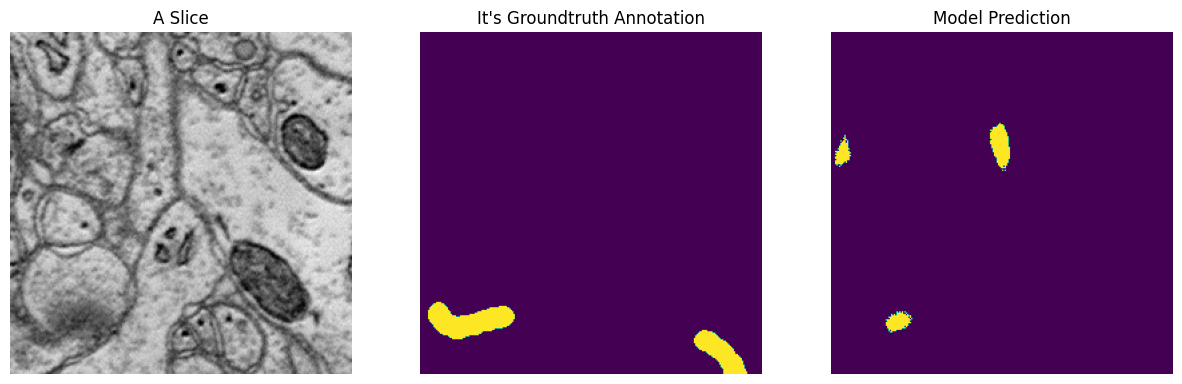

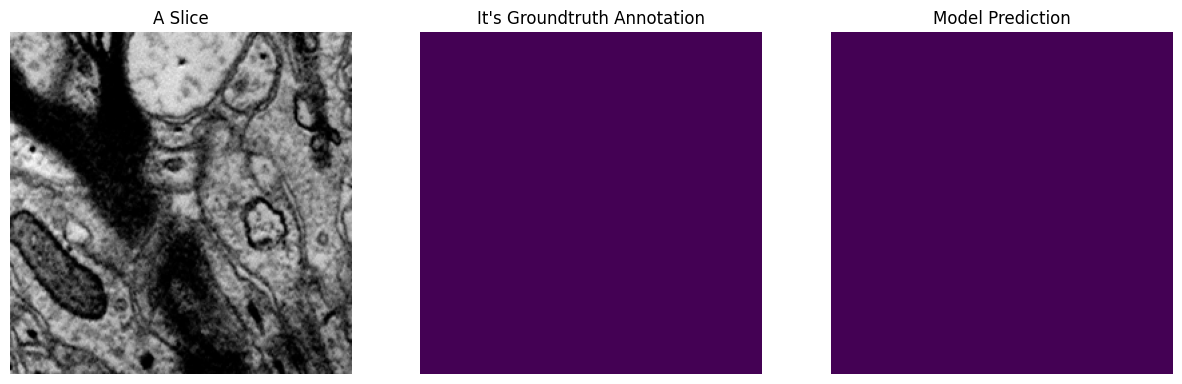

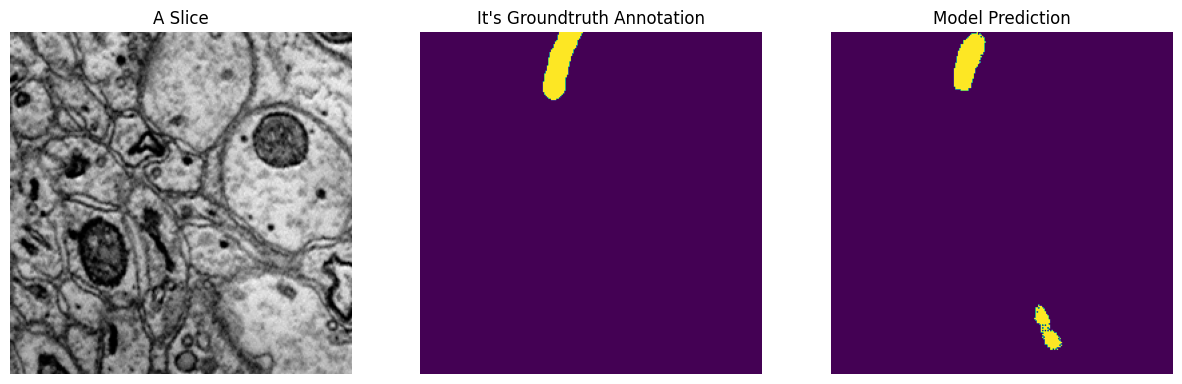

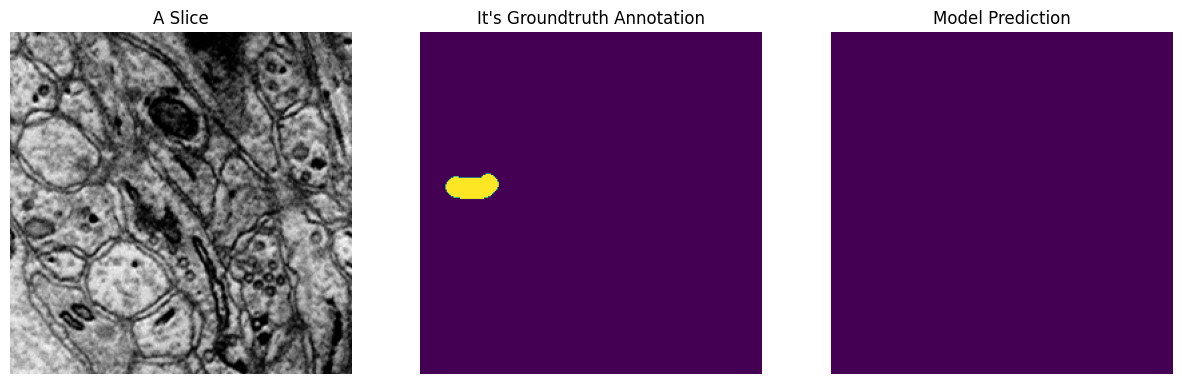

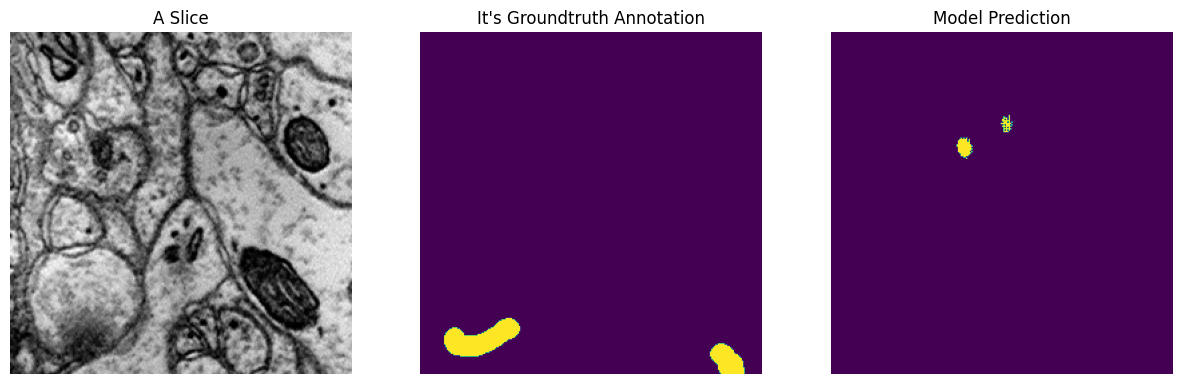

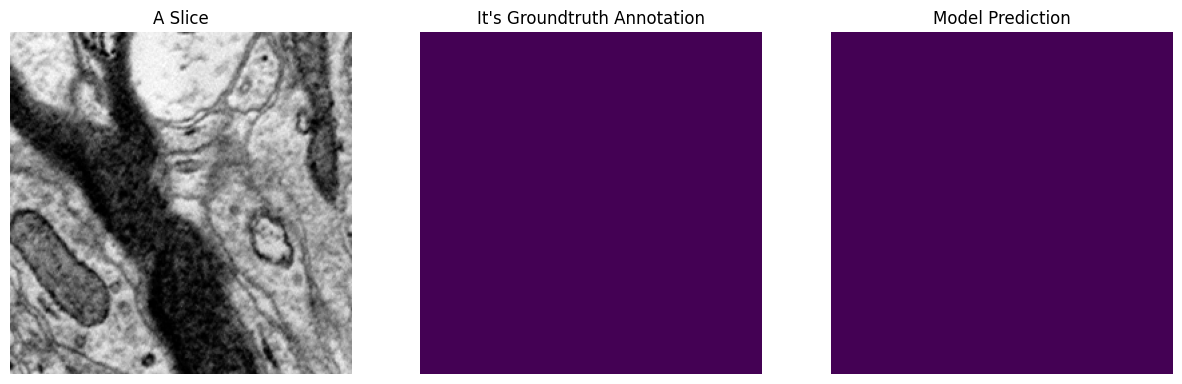

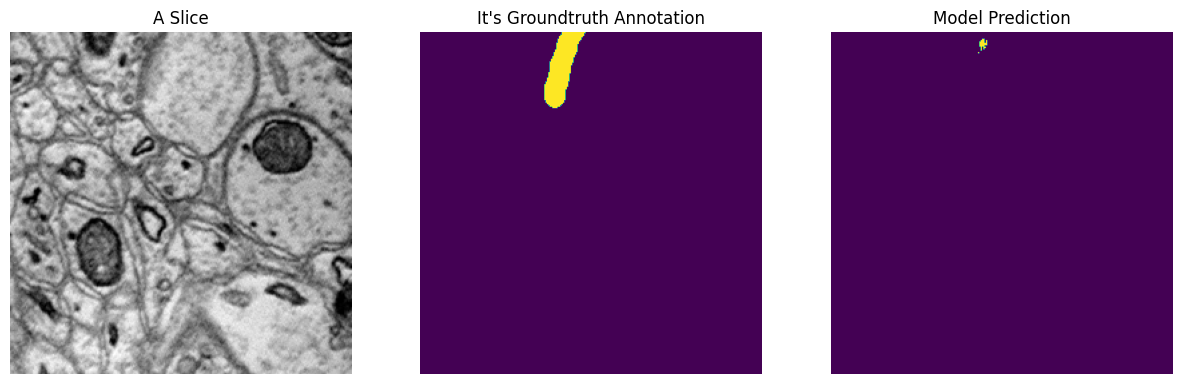

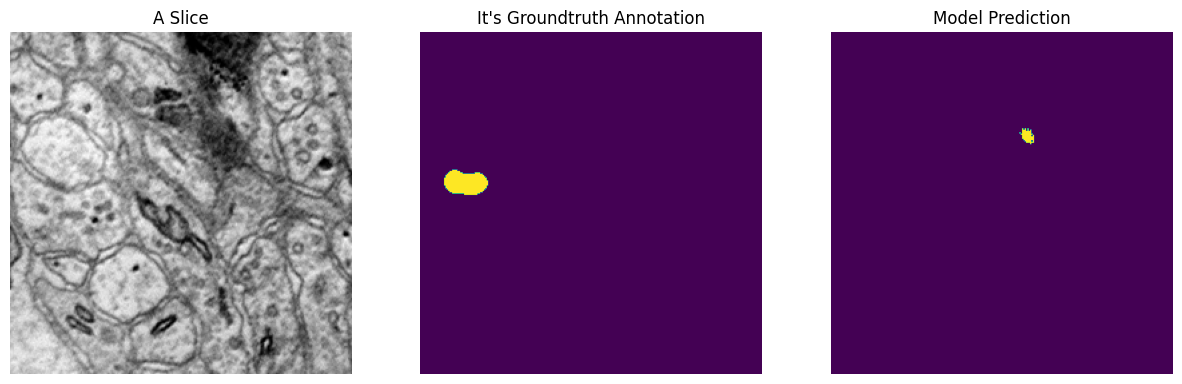

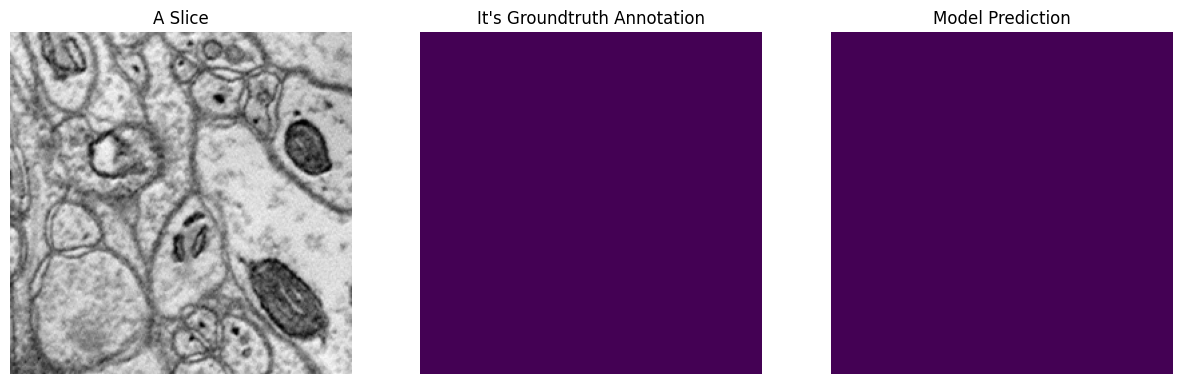

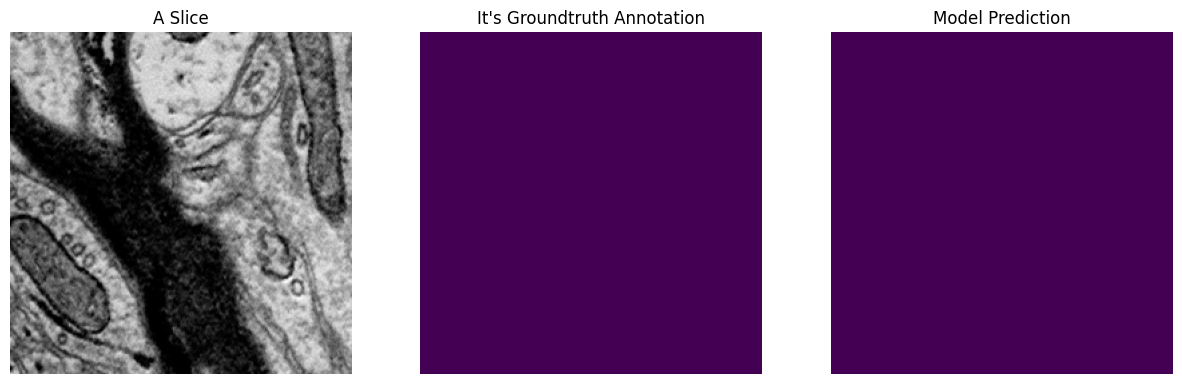

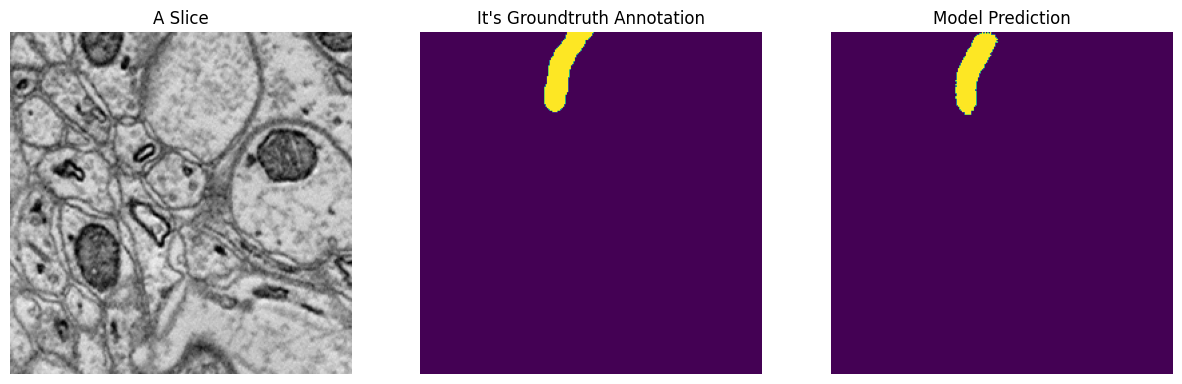

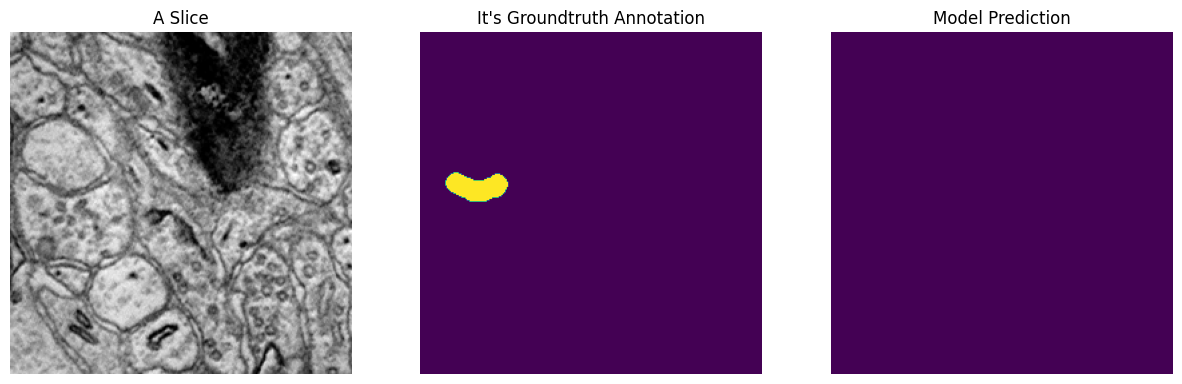

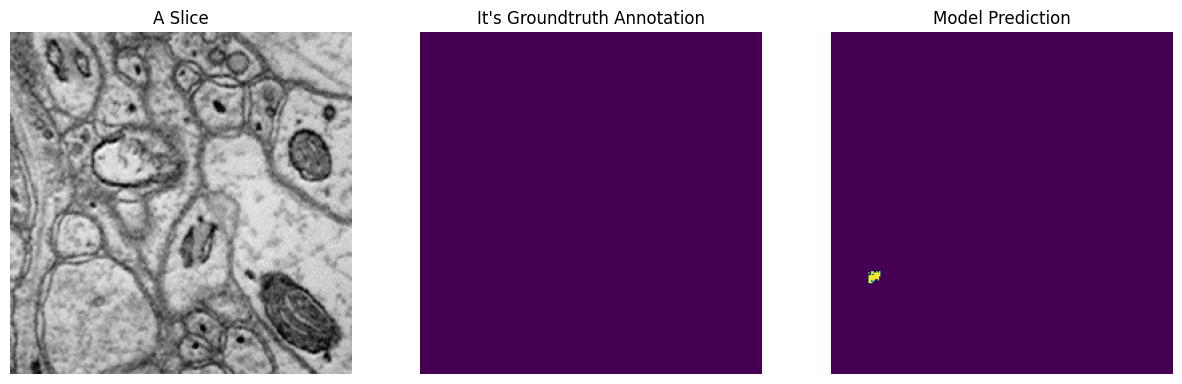

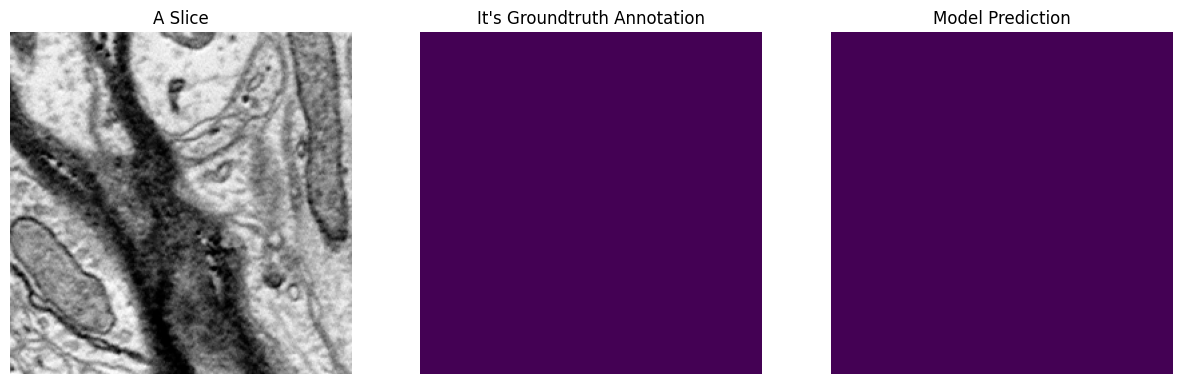

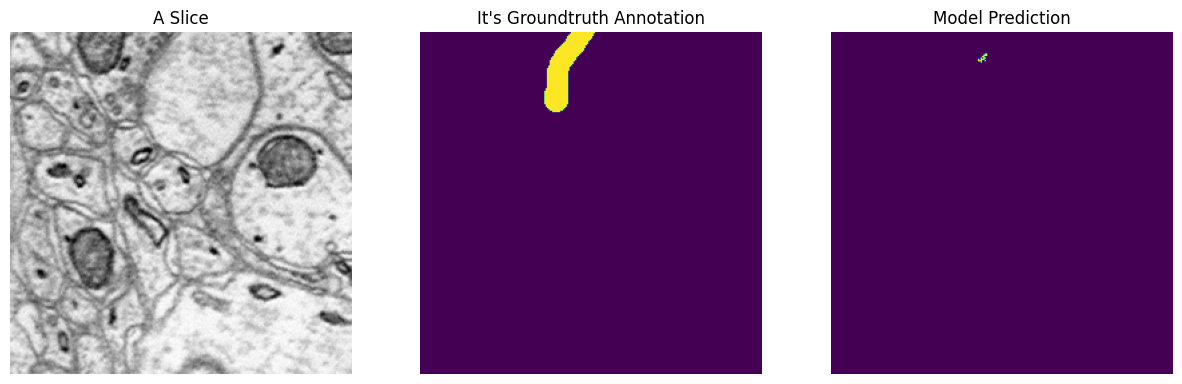

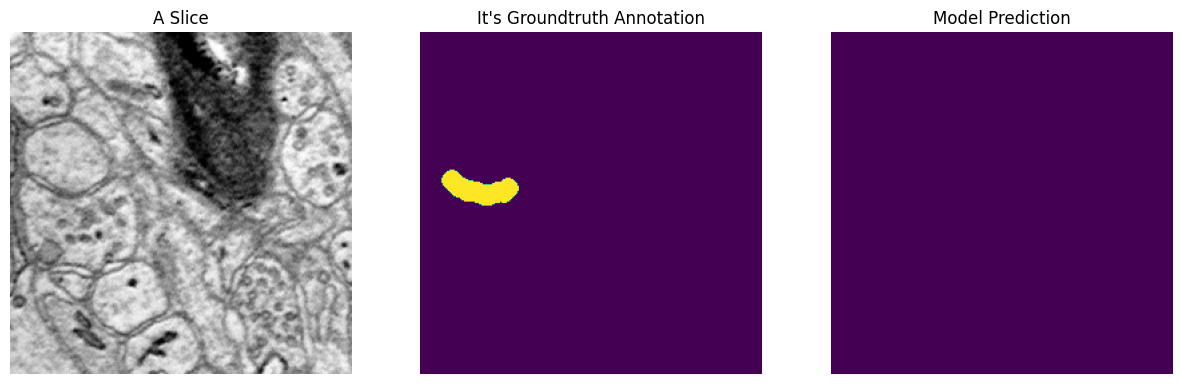

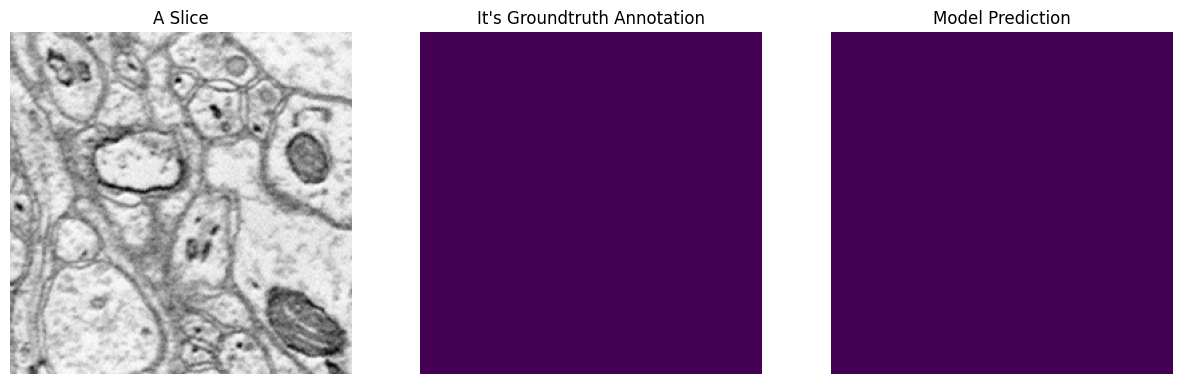

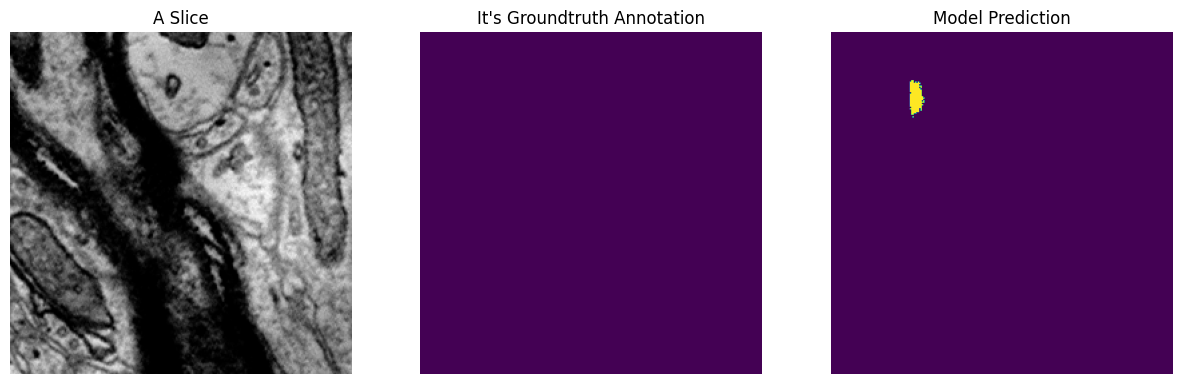

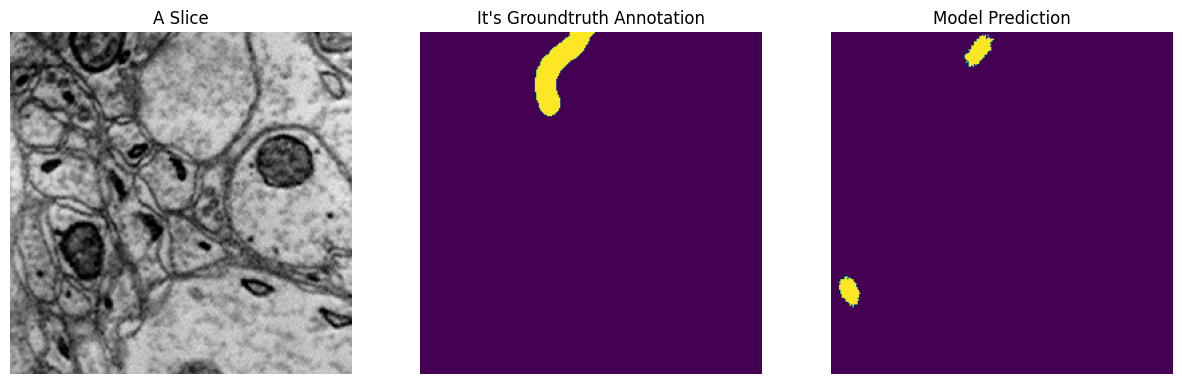

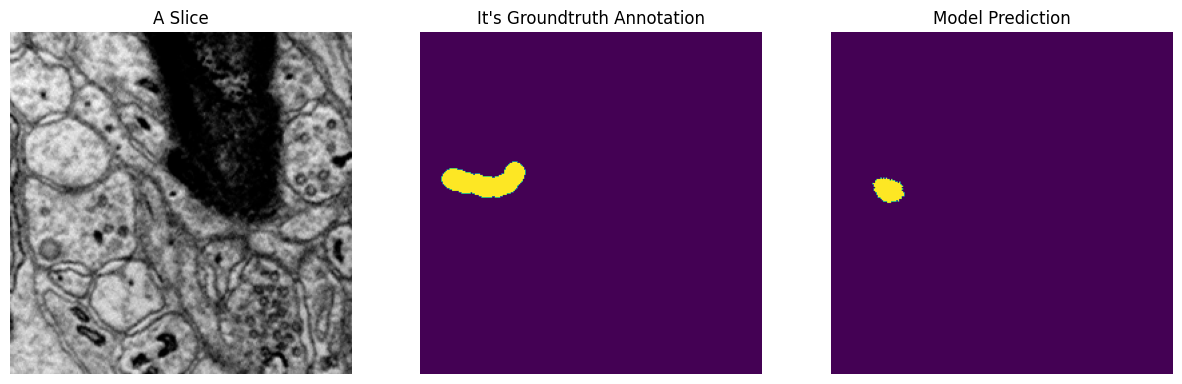

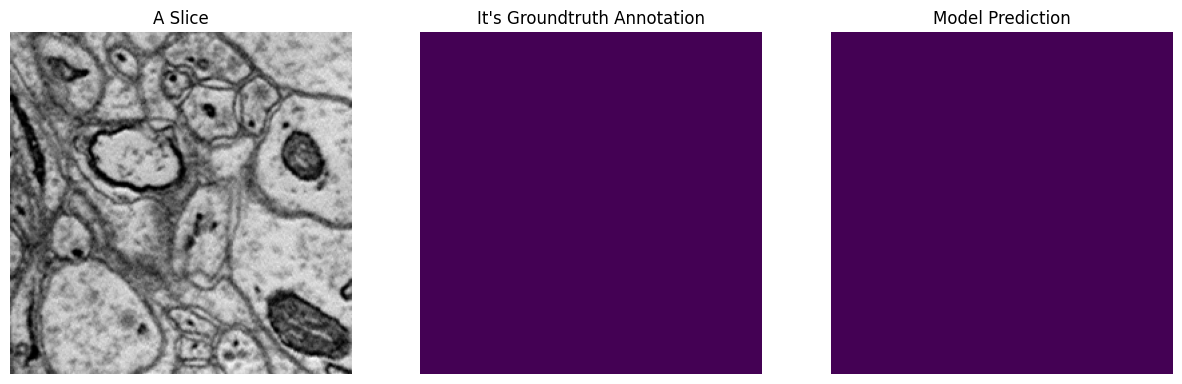

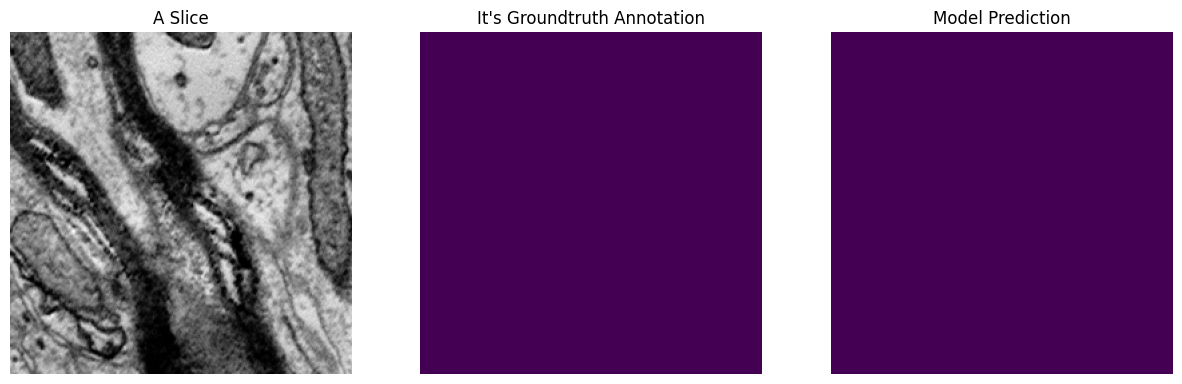

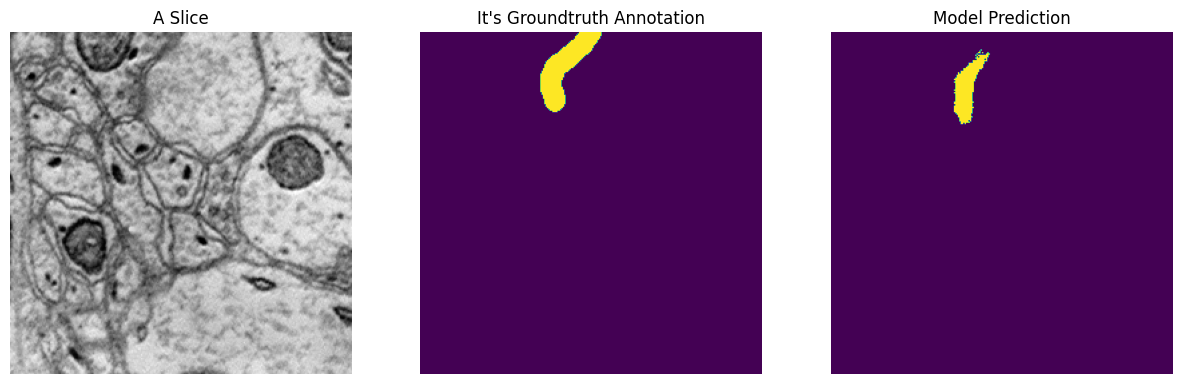

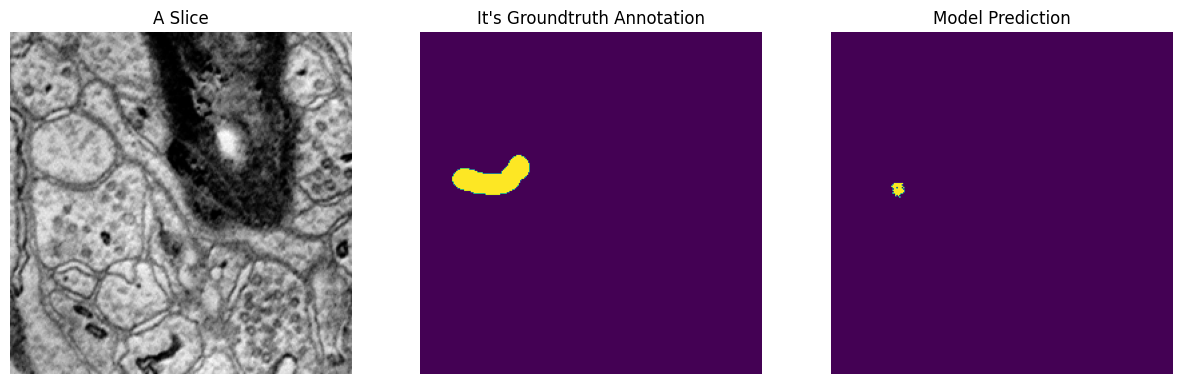

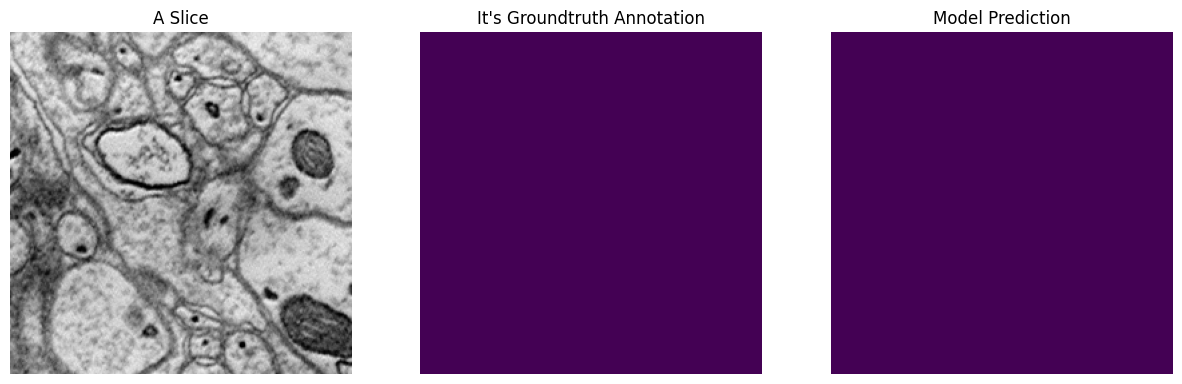

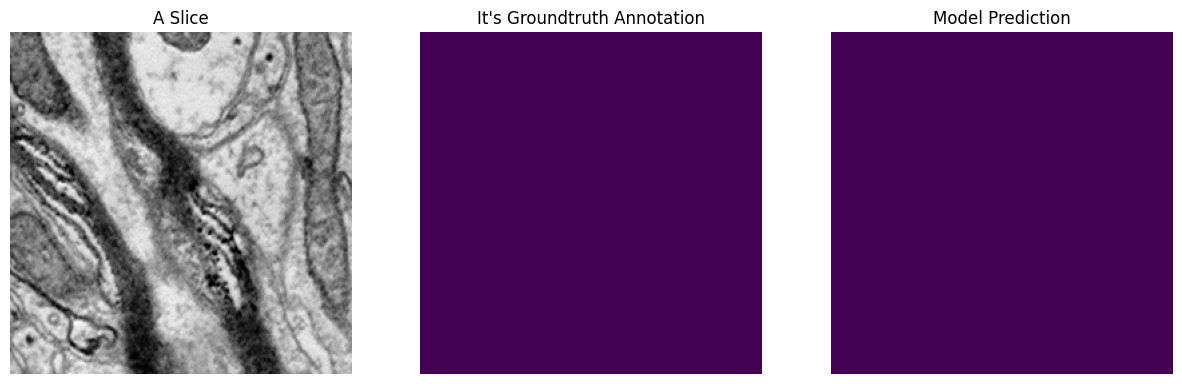

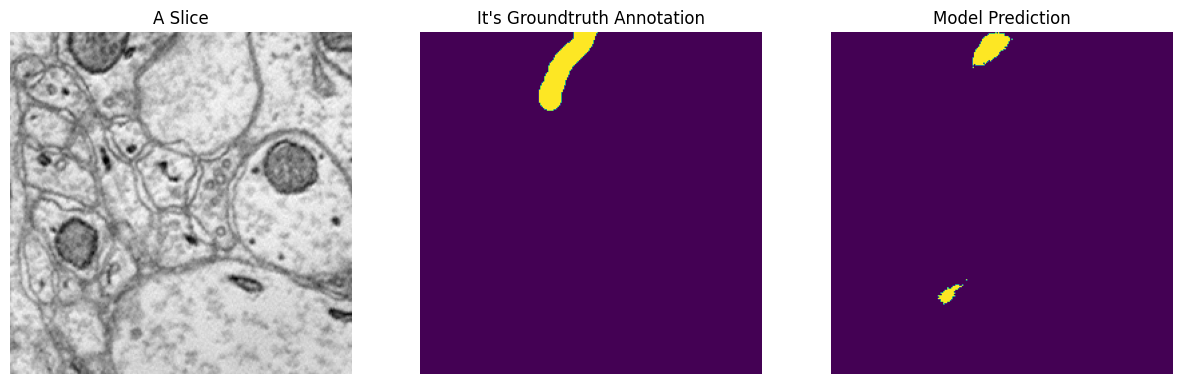

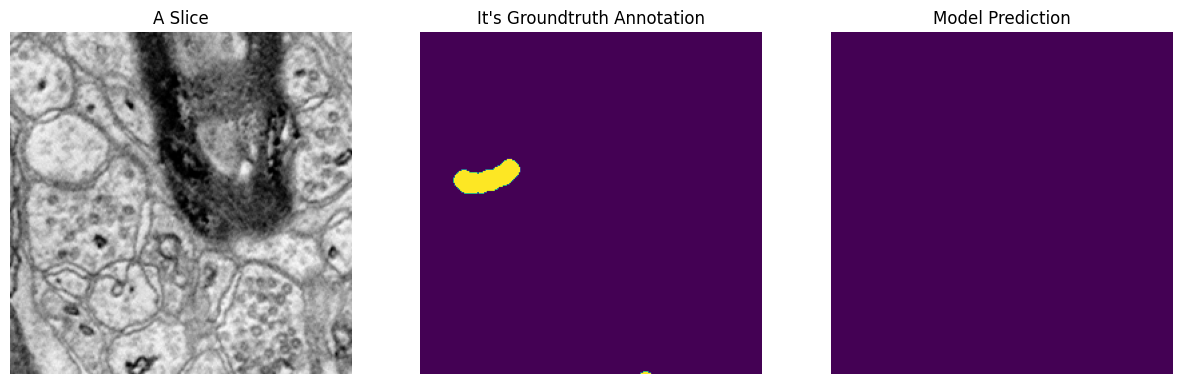

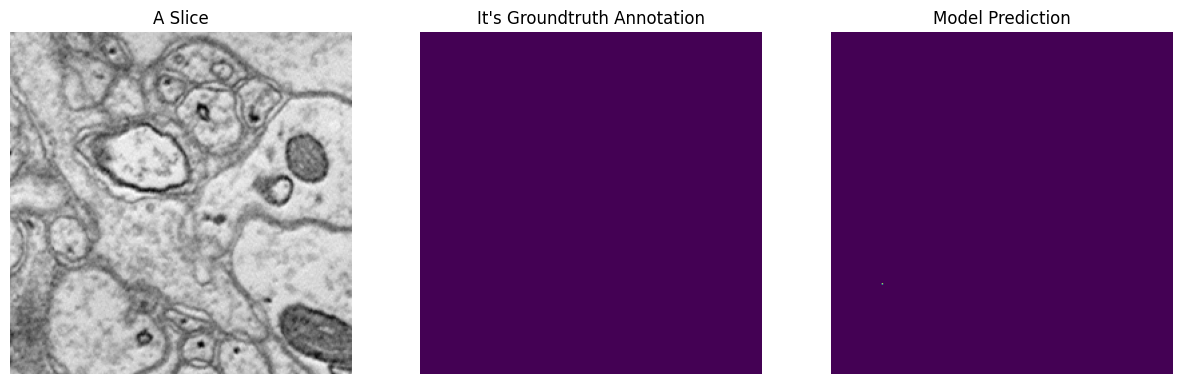

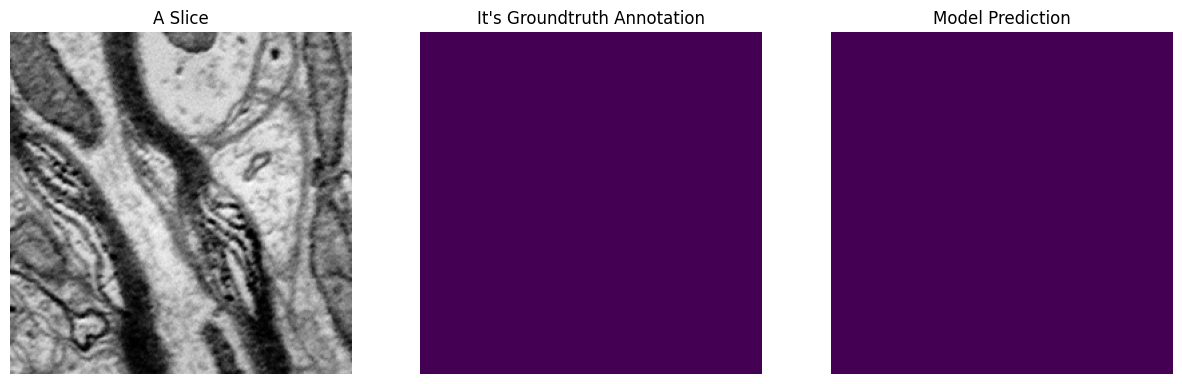

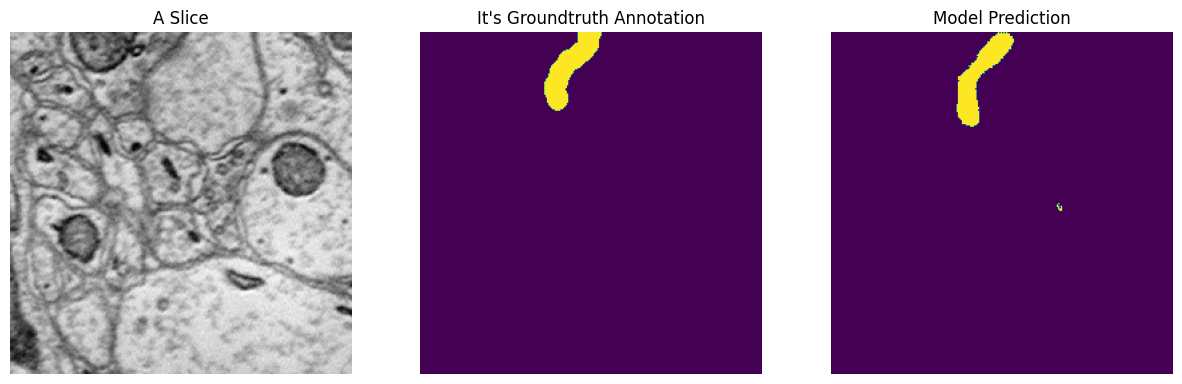

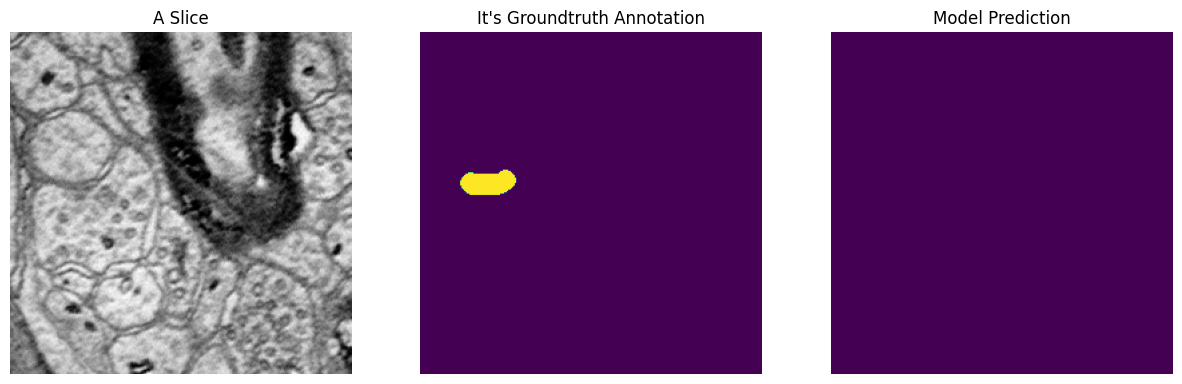

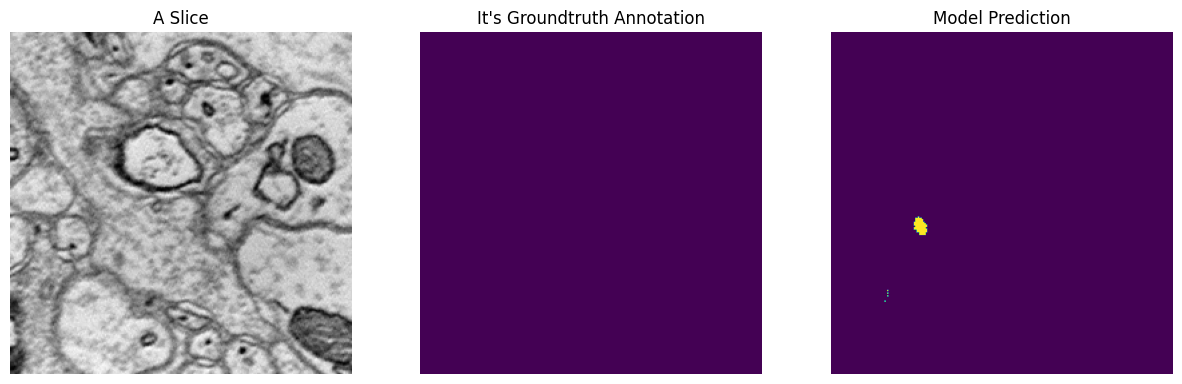

In [10]:
# Variables for storing the True Positive, False Positive, False Negative, and True Negative scores respectively
tp_tot = torch.empty(0, network_config['classes'])
fp_tot = torch.empty(0, network_config['classes'])
fn_tot = torch.empty(0, network_config['classes'])
tn_tot = torch.empty(0, network_config['classes'])

# Predict on test data
for x_batch, y_batch in test_dataloader:
    for i in range(x_batch.size(0)):  # iterate over each slice in the batch
        x = x_batch[i].unsqueeze(0)  # add a batch dimension
        y = y_batch[i].unsqueeze(0)  # add a batch dimension
        
        target = y.to(device) 
        # Segment the input image with the model
        output = predict(x, model_object, device)
        # Using segmentation_models_pytorch to calculate the statistics
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes=network_config['classes'])
        tp_tot = torch.vstack((tp_tot, tp))
        fp_tot = torch.vstack((fp_tot, fp))
        fn_tot = torch.vstack((fn_tot, fn))
        tn_tot = torch.vstack((tn_tot, tn))
        
        # Visualization
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(x.squeeze(), cmap='gray')
        ax1.title.set_text("Slice")
        ax1.axis('off')

        ax2.imshow(y.squeeze())  
        ax2.title.set_text("Groundtruth Annotation")
        ax2.axis('off')

        ax3.imshow(output.cpu().squeeze()) 
        ax3.title.set_text("Model Prediction")
        ax3.axis('off')

        plt.show()




In [11]:
# Accuracy
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('Accuracy per Class:', np.array(acc.cpu()))

# Balanced Accuracy
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'Balanced Accuracy (No Background): {balacc}')

# F1-score
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'F1-Score: {np.array(f1.cpu())}\nAvg. F1-Score: {f1.mean()}')

# IoU
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'IoU: {np.array(iou.cpu())}\nAvg. IoU-Score: {iou.mean()}')

Accuracy per Class: [0.9923004  0.99230045]
Balanced Accuracy (No Background): 0.6327617168426514
F1-Score: [0.9961264  0.37336227]
Avg. F1-Score: 0.6847443580627441
IoU: [0.9922827 0.2295301]
Avg. IoU-Score: 0.6109063625335693
